In [1]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

X_mnist_train = x_train.reshape((len(x_train), 28, 28, 1))
X_mnist_test = x_test.reshape((len(x_test), 28, 28, 1))

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Defining a discriminator
High level explanation of a discriminator is simple classifier whose job is to differentiate between real and fake MNIST digits. Fake images being from our generator

* Instead of using Max/AvgPooling layers increased stride acts as a downsampler

In [30]:
from keras.layers import Input, Dense, Conv2D, LeakyReLU, Dropout, Flatten
from keras.models import Model
from keras.optimizers import Adam

def discriminator_model(input_shape = (28, 28, 1)) -> Model:
    
    network_input = Input(shape=input_shape)
    
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Dropout(0.4)(layer)
    layer = Flatten()(layer)
    layer = Dense(1, activation='sigmoid')(layer)
    
    model = Model(network_input, layer)
    
    adam = Adam(lr=0.0002, beta_1=0.5)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

discriminator = discriminator_model()
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 64)        640       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 7, 7, 64)          0         
__________

## Generating a REAL + FAKE dataset
MNIST dataset gave us real images, but our model requires fake models to differentiate from real ones

In [3]:
def generate_real_samples(dataset: np.ndarray, n_samples: int) -> (np.ndarray, np.ndarray):
    
    random_sample_indexes = np.random.randint(0, dataset.shape[0], n_samples)
    random_samples = x_train[random_sample_indexes]
    
    random_samples = random_samples.reshape((n_samples, 28, 28, 1))
    
    return (random_samples, np.ones((n_samples, 1)))


def generate_fake_samples(n_samples: int) -> (np.ndarray, np.ndarray):
    
    X = np.random.rand(28 * 28 * n_samples)
    X = X.reshape((n_samples, 28, 28, 1))
    
    return (X, np.zeros((n_samples, 1)))

In [4]:
import matplotlib.pyplot as plt

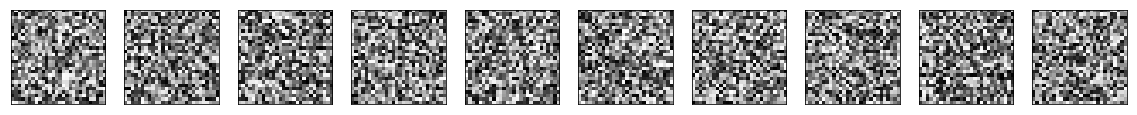

In [5]:
fake_images, _ = generate_fake_samples(10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(fake_images[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## About the discriminator
* Since we defined the architecture of the discriminator we are going to train it sequentaly with the whole GAN, not by itself

## Defining a generator

In [6]:
from keras.layers import Reshape, Conv2DTranspose

In [28]:
def generator_model(latent_dim: int) -> Model:
    
    network_input = Input(shape=(latent_dim,))
    
    layer = Dense(128 * 7 * 7)(network_input)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Reshape((7, 7, 128))(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(layer)
    layer = LeakyReLU(alpha=0.2)(layer)
    layer = Conv2D(1, (7, 7), activation='sigmoid', padding='same')(layer)
    
    model =  Model(network_input, layer)
        
    return model

In [29]:
generator = generator_model(100)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 6272)              0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 128)       262272    
__________

In [9]:
def generate_latent_points(latent_dim: int, n_samples: int) -> np.ndarray:
    
    x_input = np.random.randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [10]:
def generate_fake_generator_samples(generator: Model, latent_dim: int, n_samples: int) -> (np.ndarray, np.ndarray):
    
    x_input = generate_latent_points(latent_dim, n_samples)
    
    X = generator.predict(x_input)
    
    y = np.zeros((n_samples, 1)) # Zeros because we want to convince the generator that these are fakes
    
    return X, y

### Initial generator examples

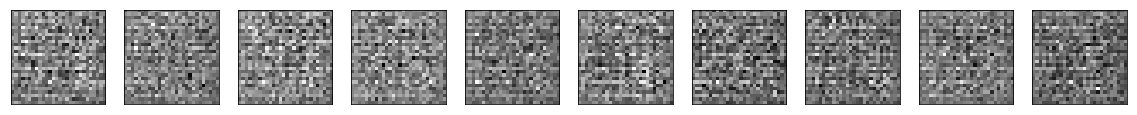

In [11]:
initial_generator_samples, _ = generate_fake_generator_samples(generator, 100, 10)

plt.figure(figsize=(20, 20))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.imshow(initial_generator_samples[i].reshape((28, 28)))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

## Defining a generator

In [12]:
from keras.models import Sequential

In [13]:
def define_gan(g_model: Model, d_model: Model) -> Model:
    
    d_model.trainable = False
    
    model = Sequential()
    
    model.add(g_model)
    
    model.add(d_model)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model

In [31]:
gan_model = define_gan(generator, discriminator)
gan_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_6 (Model)              (None, 28, 28, 1)         1164289   
_________________________________________________________________
model_7 (Model)              (None, 1)                 40705     
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


## Training the GAN model

In [41]:
def test_generator(generator: Model, latent_dim: int, examples: int):
    
    generator_output = generate_fake_generator_samples(generator, latent_dim, examples)[0]
    plt.figure(figsize=(20, 20))
    for i in range(10):
        ax = plt.subplot(1, 10, i + 1)
        plt.imshow(generator_output[i].reshape((28, 28)))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

### Setting up tensorboard

In [37]:
from keras.callbacks import TensorBoard

In [56]:
def tensorboard(log_dir, batch_size: int, model: Model) -> TensorBoard:
    
    _tensorboard = TensorBoard(log_dir=log_dir,
                               histogram_freq=0,
                               batch_size=batch_size,
                               write_graph=True, 
                               write_grads=True)
    
    _tensorboard.set_model(model)
    
    return _tensorboard

def named_logs(model: Model, logs) -> dict:
    
    result = {}
    
    for l in zip(model.metrics_names, logs):
        result[l[0]] = l[1]
    
    return result

In [57]:
def train(log_dir:str, log_model: Model, g_model: Model, d_model: Model, gan_model: Model, dataset: np.ndarray, latent_dim: int, n_epochs=100, n_batch=256):
    
    batches_per_epoch = int(dataset.shape[0] / n_epochs)
    half_batch = int(n_batch / 2)
    
    _tensorboard = tensorboard(log_dir, n_batch, log_model)
    
    for i in range(n_epochs):
        for j in range(batches_per_epoch):
            
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_generator_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            d_loss = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            
            y_gan = np.ones((n_batch, 1))
            
            g_loss = gan_model.train_on_batch(X_gan, y_gan)
            
            if (j + 1) % batches_per_epoch == 0:
                print(f'{i+1}, {j+1}/{batches_per_epoch}, d={d_loss}, g={g_loss}')
                
        _tensorboard.on_epoch_end(i + 1, named_logs(log_model, [g_loss]))
        
        if (i + 1) % 10 == 0:
            test_generator(g_model, latent_dim, 10)

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1, 20/20, d=[0.6840726, 0.59375], g=0.7002383470535278
2, 20/20, d=[0.678532, 0.58984375], g=0.691658616065979
3, 20/20, d=[0.68595195, 0.5546875], g=0.6987825036048889
4, 20/20, d=[0.68122226, 0.578125], g=0.6908718347549438
5, 20/20, d=[0.6830855, 0.5703125], g=0.6984941959381104
6, 20/20, d=[0.67705727, 0.56640625], g=0.6929699182510376
7, 20/20, d=[0.6945176, 0.52734375], g=0.6942058205604553
8, 20/20, d=[0.67874503, 0.58984375], g=0.7057052850723267
9, 20/20, d=[0.6851438, 0.58203125], g=0.7170116901397705
10, 20/20, d=[0.6893568, 0.52734375], g=0.7189422845840454


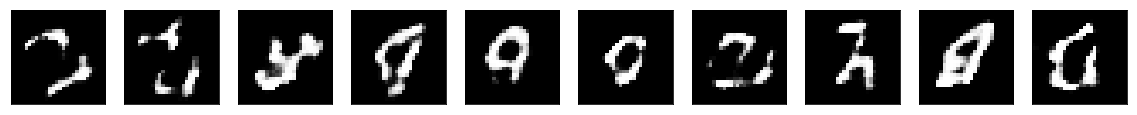

11, 20/20, d=[0.6775523, 0.5625], g=0.6860994696617126
12, 20/20, d=[0.69697005, 0.4765625], g=0.655474841594696
13, 20/20, d=[0.6897983, 0.49609375], g=0.6907042860984802
14, 20/20, d=[0.6848737, 0.5546875], g=0.731595516204834
15, 20/20, d=[0.6725019, 0.60546875], g=0.7491682767868042
16, 20/20, d=[0.6876453, 0.55078125], g=0.6837698817253113
17, 20/20, d=[0.6671268, 0.63671875], g=0.7623839974403381
18, 20/20, d=[0.6866591, 0.5625], g=0.710982620716095
19, 20/20, d=[0.6758239, 0.578125], g=0.6883348226547241
20, 20/20, d=[0.6777905, 0.6015625], g=0.7260531783103943


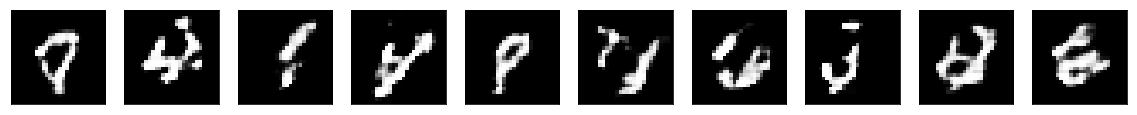

21, 20/20, d=[0.6906159, 0.52734375], g=0.6724589467048645
22, 20/20, d=[0.68293893, 0.57421875], g=0.7520020008087158
23, 20/20, d=[0.67762536, 0.57421875], g=0.6859355568885803
24, 20/20, d=[0.6814136, 0.5546875], g=0.7340884804725647
25, 20/20, d=[0.6874608, 0.53125], g=0.7387873530387878
26, 20/20, d=[0.6969192, 0.5234375], g=0.6642211079597473
27, 20/20, d=[0.6742707, 0.6015625], g=0.7909453511238098
28, 20/20, d=[0.6976294, 0.48046875], g=0.6856307983398438
29, 20/20, d=[0.66784346, 0.640625], g=0.7090069055557251
30, 20/20, d=[0.6919514, 0.5], g=0.6945213079452515


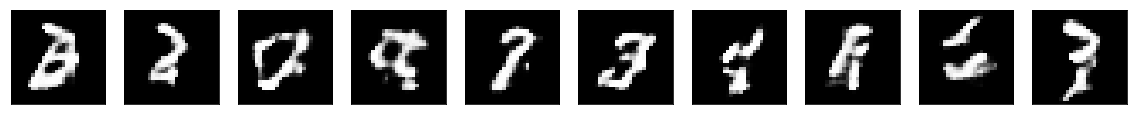

31, 20/20, d=[0.687588, 0.54296875], g=0.7184297442436218
32, 20/20, d=[0.6770482, 0.62890625], g=0.7267144918441772
33, 20/20, d=[0.6907997, 0.54296875], g=0.6879976987838745
34, 20/20, d=[0.6913522, 0.5078125], g=0.6969448924064636
35, 20/20, d=[0.688297, 0.546875], g=0.7038691639900208
36, 20/20, d=[0.68186736, 0.57421875], g=0.7108932733535767
37, 20/20, d=[0.67798716, 0.6015625], g=0.6863663792610168
38, 20/20, d=[0.68341196, 0.578125], g=0.7255290746688843
39, 20/20, d=[0.68626964, 0.56640625], g=0.7325695157051086
40, 20/20, d=[0.68711317, 0.5390625], g=0.7124096155166626


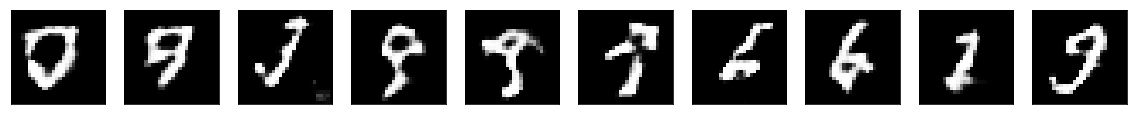

41, 20/20, d=[0.6854816, 0.55859375], g=0.6681545972824097
42, 20/20, d=[0.68877596, 0.51171875], g=0.7205736637115479
43, 20/20, d=[0.67475784, 0.63671875], g=0.7317030429840088
44, 20/20, d=[0.68285024, 0.56640625], g=0.7130207419395447
45, 20/20, d=[0.68149376, 0.57421875], g=0.6741302609443665
46, 20/20, d=[0.6800384, 0.57421875], g=0.6982280611991882
47, 20/20, d=[0.7020822, 0.46484375], g=0.7532390356063843
48, 20/20, d=[0.6852075, 0.56640625], g=0.6964370012283325
49, 20/20, d=[0.6769081, 0.58984375], g=0.7377063035964966
50, 20/20, d=[0.69078773, 0.51171875], g=0.7224447131156921


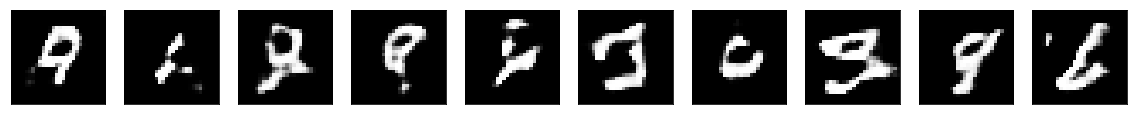

In [59]:
train('tf_logs', gan_model, generator, discriminator, gan_model, X_mnist_train[:1000], 100, 50)

(10, 28, 28, 1)


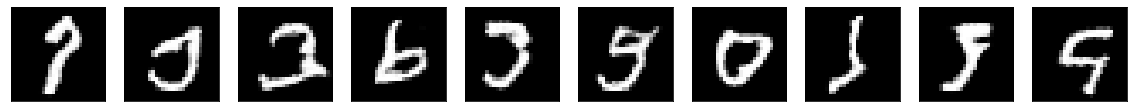

In [28]:
test_generator(generator, 100, 10)